In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [3]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [4]:
warnings.filterwarnings("ignore")

In [5]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(column)

    plt.show()

In [6]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)
    moving_averages = []

    for i in range(start_index, end_index + 1):
        start = max(0, i - window_size)
        end = min(data_length, i + window_size + 1)
        window = data[start:end]
        valid_values = [value for value in window if not pd.isna(value)]
        if len(valid_values) > 0:
            moving_averages.append(np.mean(valid_values))
        else:
            moving_averages.append(np.nan)

    modified_data = data.copy()
    modified_data[start_index:end_index + 1] = moving_averages
    modified_column = pd.Series(modified_data, name=column.name)

    return modified_column

In [7]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [8]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

In [9]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('dados_imobilidarios_bcb.csv')
df.head(len(df))

,DateTime,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
0,2014-01-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-02-28,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-03-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-04-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-05-31,4.824127e+07,2.739426e+08,2.397400e+09,2.675238e+09,6.697185e+09,4.018676e+08,2

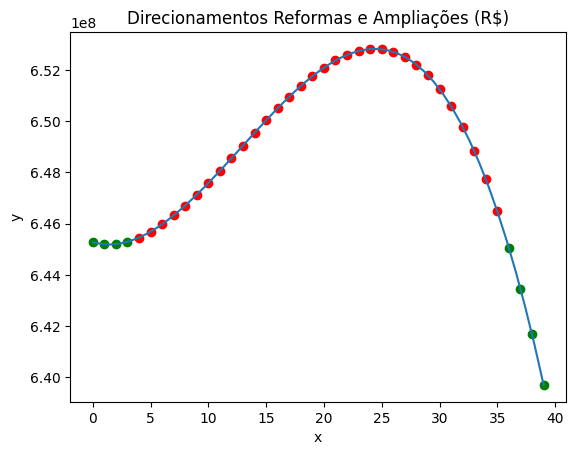

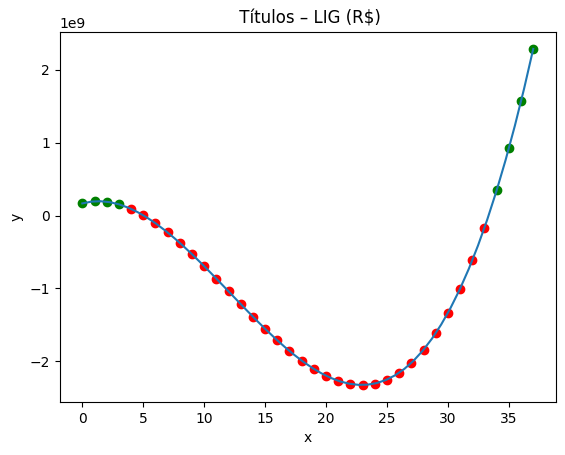

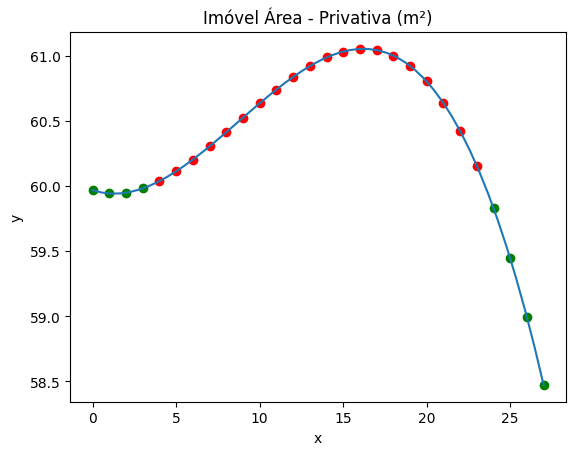

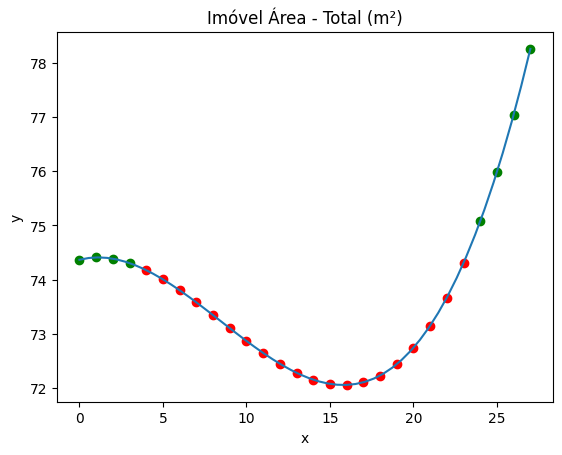

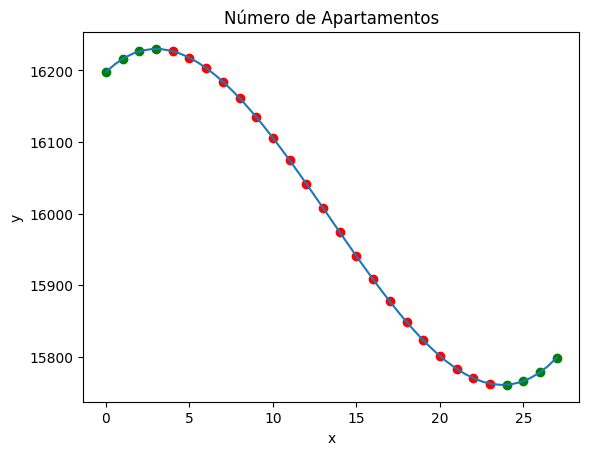

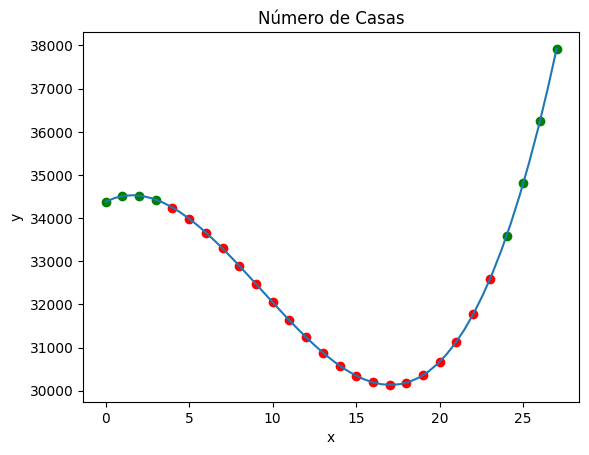

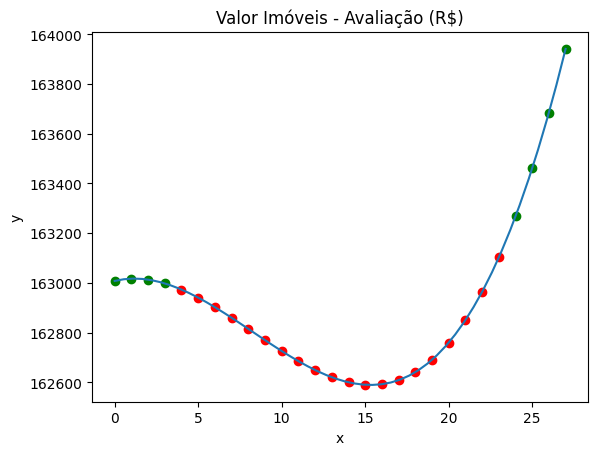

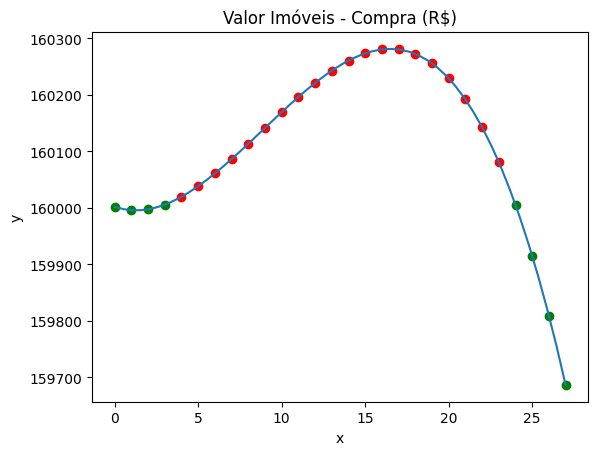

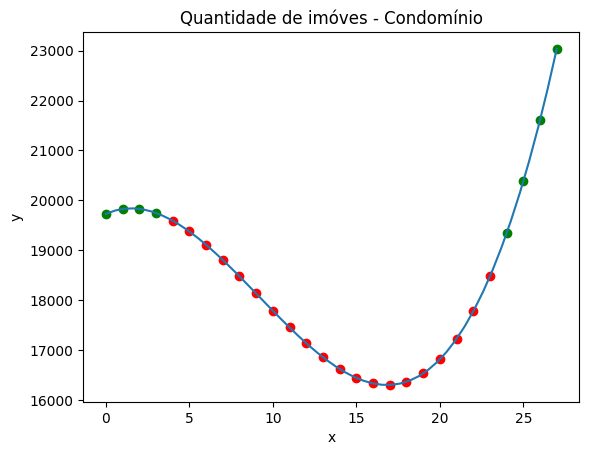

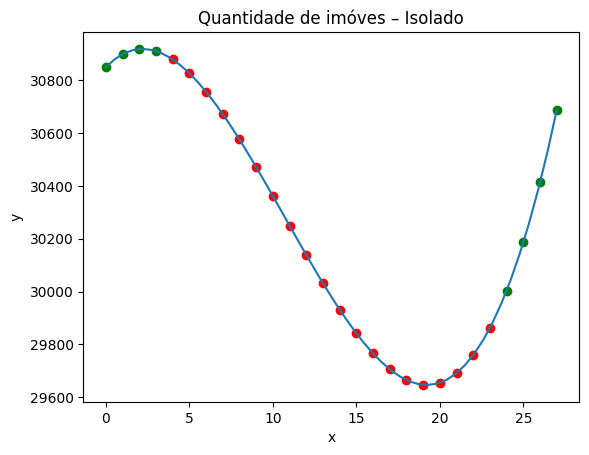

,DateTime,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
0,2014-01-30,4.662068e+07,2.460053e+08,1.898133e+09,3.272294e+09,4.400998e+09,1.316370e+08,7.238672e+07,4.184620e+08,5.181179e+08,3.244417e+11,2.289097e+10,6.452397e+08,3.542036e+11,1.514587e+07,9.680057e+08,1.767638e+09,8.931303e+09,9.661752e+09,1.715931e+07,3.651412e+08,4.216442e+07,4.049929e+08,9.775880e+08,1.155475e+10,6.845529e+10,1.518386e+11,2.057276e+11,1.303650e+09,3.427114e+09,2.663783e+10,2.698349e+10,1.450000,2.192000,1.437200,1.033200,4.644000,0.406400,0.701200,0.696800,0.111905,5.012533e+11,1.268306e+09,1.772018e+08,5.081997e+10,1.537490e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
1,2014-02-28,4.628381e+07,2.426754e+08,1.854342e+09,3.263301e+09,4.298521e+09,1.272205e+08,7.584683e+07,4.031240e+08,5.041980e+08,3.266305e+11,2.307696e+10,6.452397e+08,3.552153e+11,1.580254e+07,9.841771e+08,1.800587e+09,8.971996e+09,9.711099e+09,1.735188e+07,3.845475e+08,4.457677e+07,4.149718e+08,1.012198e+09,1.155975e+10,6.851841e+10,1.533245e+11,2.068706e+11,1.293085e+09,3.757432e+09,2.652321e+10,2.698681e+10,1.461538,2.189231,1.462692,1.046154,4.708077,0.446538,0.745769,0.716154,0.124091,5.011778e+11,1.263922e+09,1.772018e+08,5.121251e+10,1.552401e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
2,2014-03-30,4.637517e+07,2.411804e+08,1.815624e+09,3.260343e+09,4.275683e+09,1.236349e+08,8.040104e+07,3.905919e+08,4.897281e+08,3.287596e+11,2.326019e+10,6.452397e+08,3.562207e+11,1.657602e+07,1.000767e+09,1.826296e+09,9.056963e+09,9.725136e+09,1.750692e+07,4.028225e+08,4.678299e+07,4.282588e+08,1.044965e+09,1.156358e+10,6.836398e+10,1.541091e+11,2.088757e+11,1.285387e+09,4.066708e+09,2.642082e+10,2.698372e+10,1.470000,2.181111,1.490000,1.063704,4.772222,0.475556,0.783704,0.738519,0.135652,5.010276e+11,1.260657e+09,1.772018e+08,5.158539e+10,1.566571e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
3,2014-04-30,4.616784e+07,2.401782e+08,1.773962e+09,3.287919e+09,4.196563e+09,1.195879e+08,8.205609e+07,3.793010e+08,4.783224e+08,3.307563e+11,2.344144e+10,6.452397e+08,3.570830e+11,1.752937e+07,1.017437e+09,1.845176e+09,9.115674e+09,9.794288e+09,1.785135e+0

In [10]:
df_interpolated = read_csv_replace_missing_by_polynomial('dados_imobilidarios_bcb.csv', 0, 0)
df_interpolated

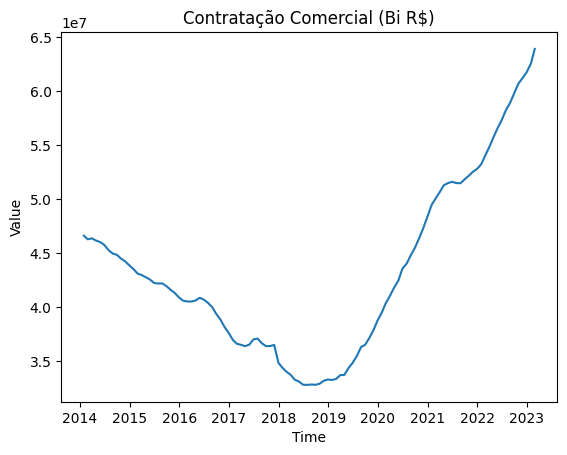

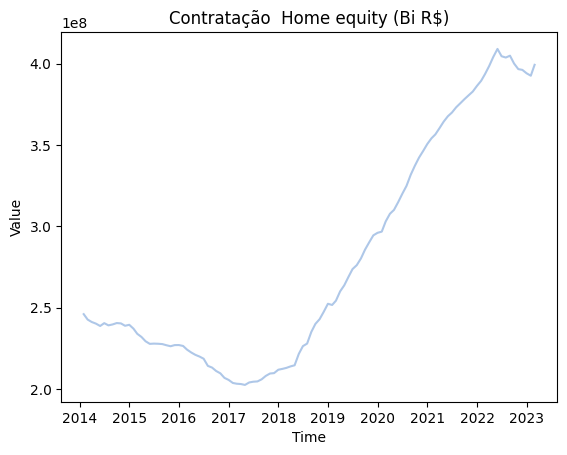

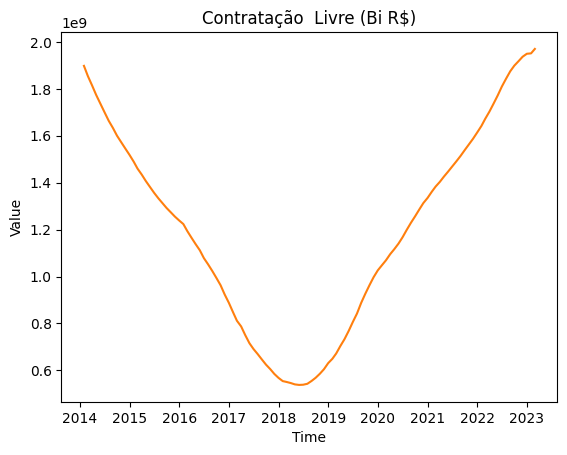

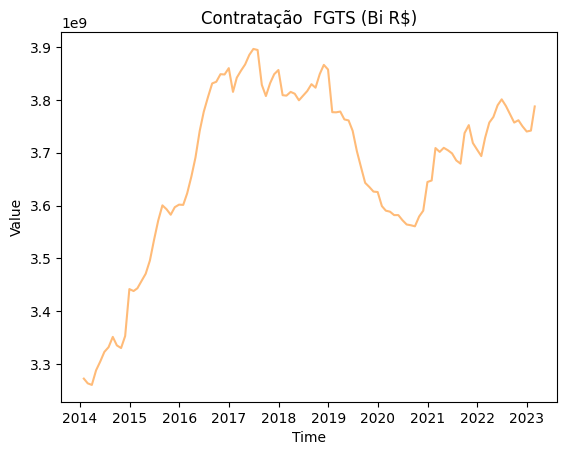

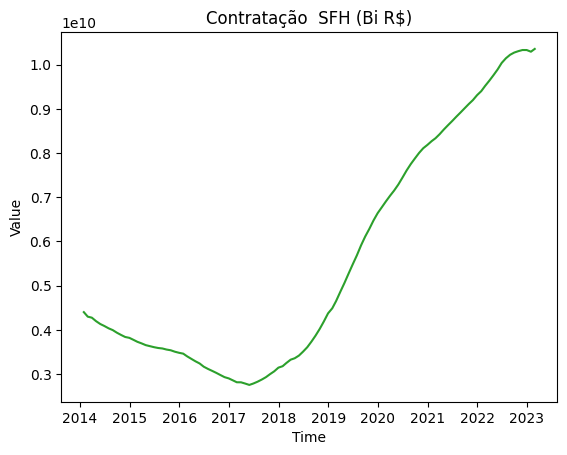

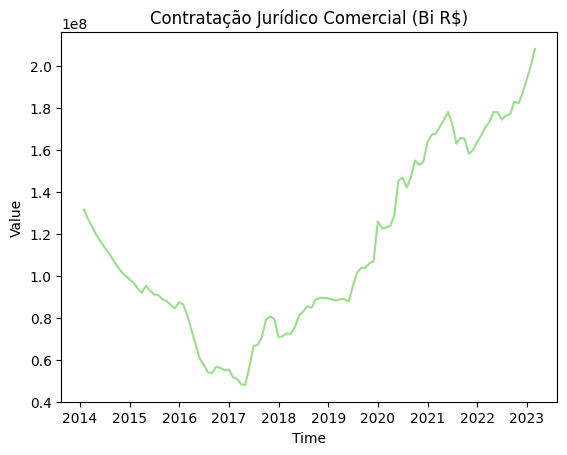

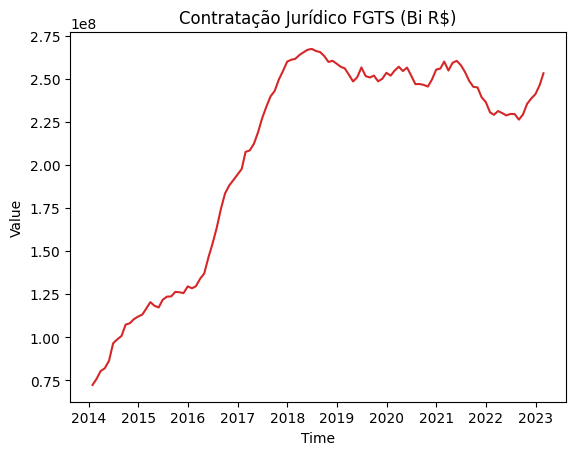

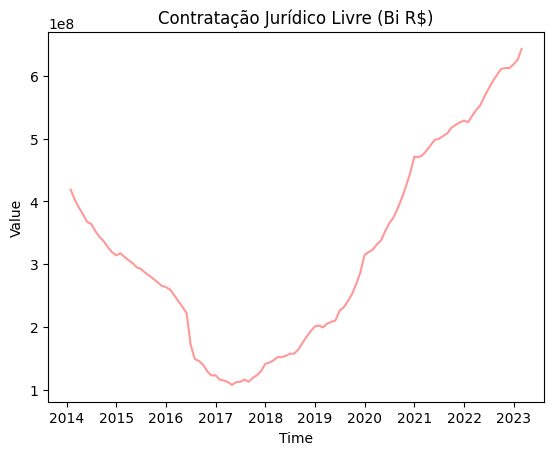

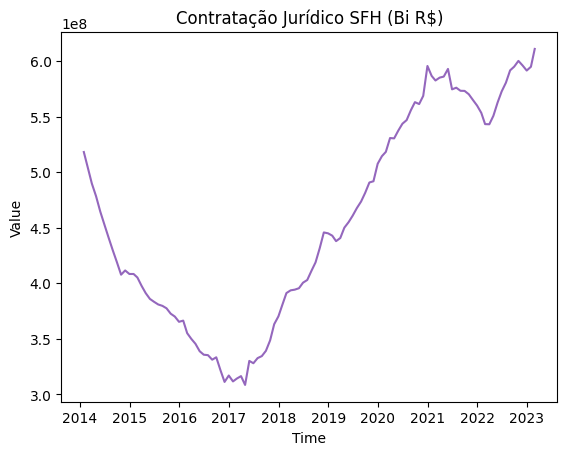

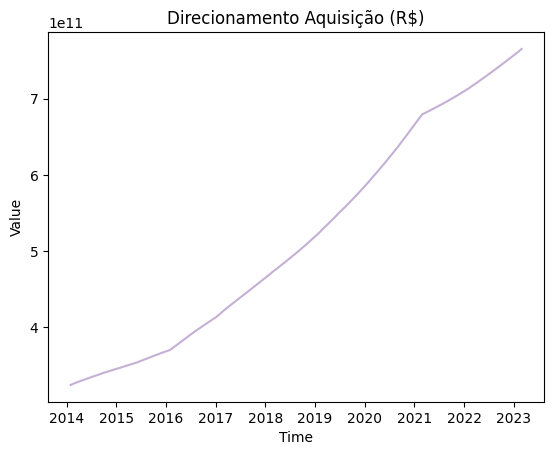

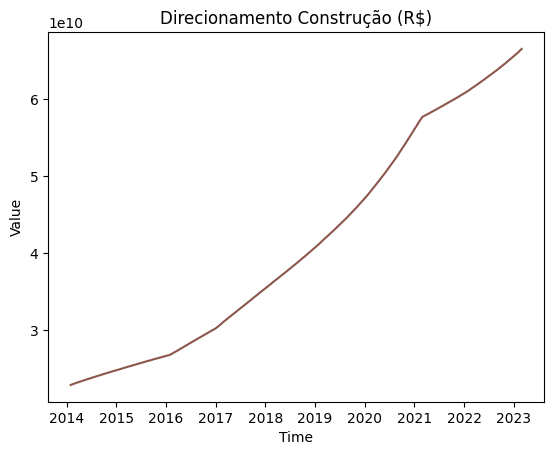

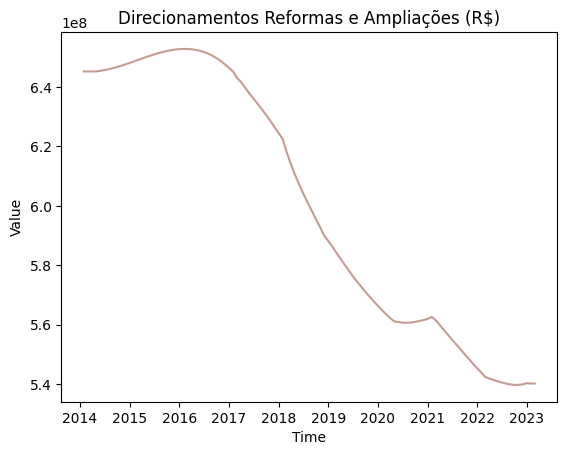

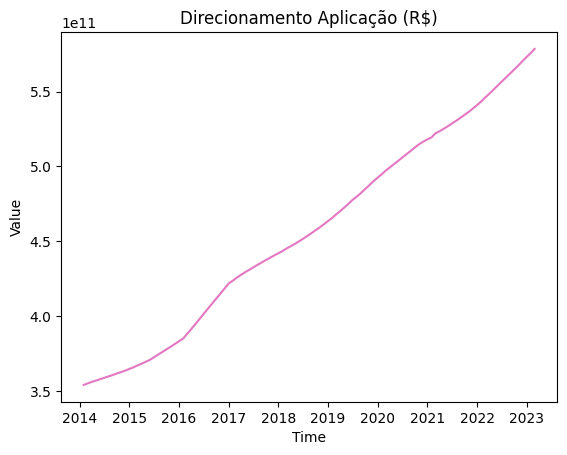

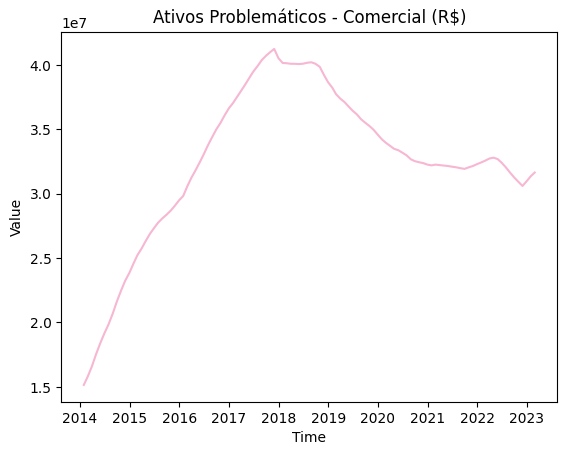

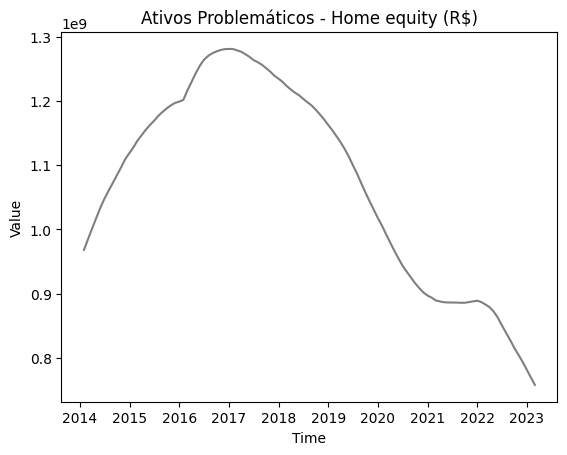

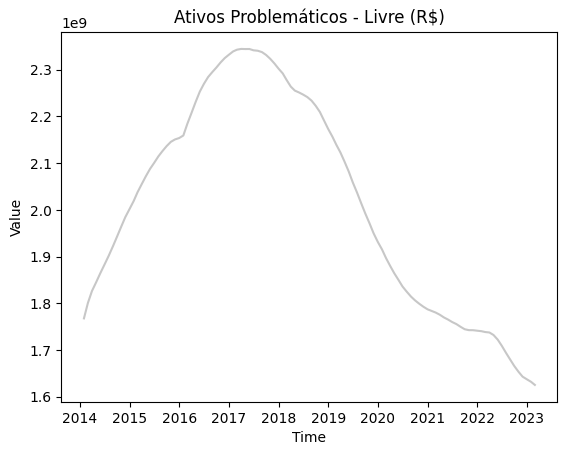

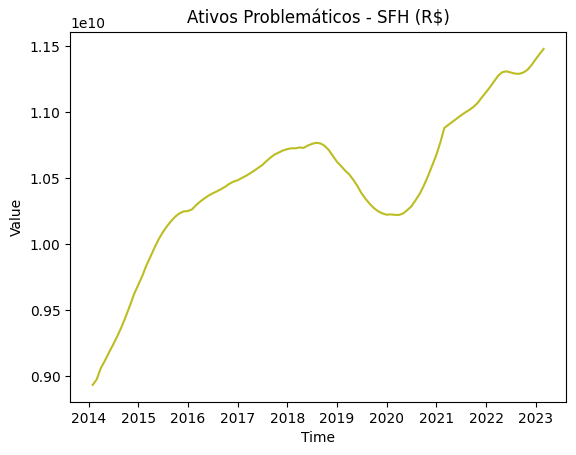

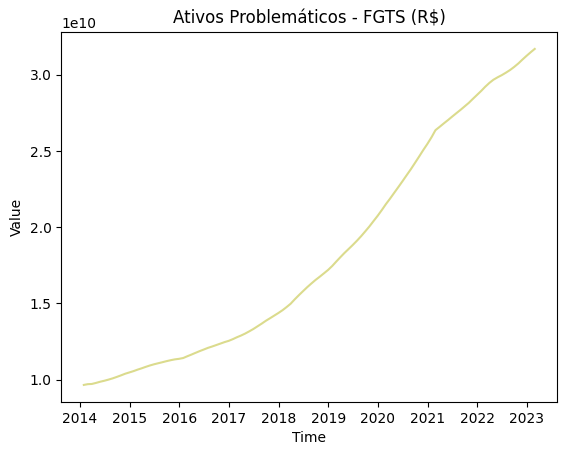

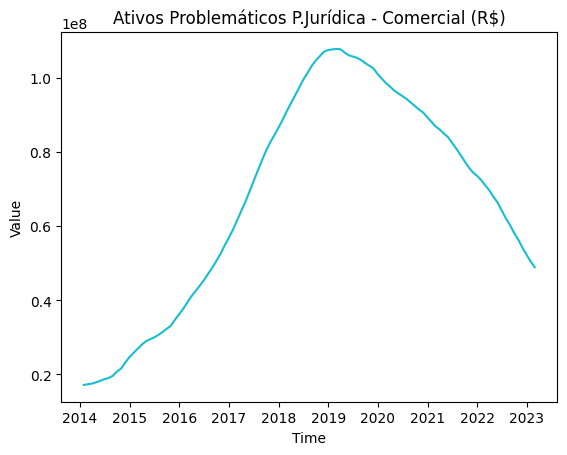

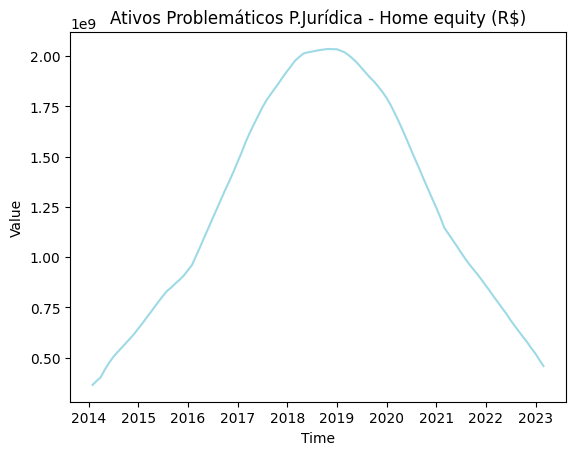

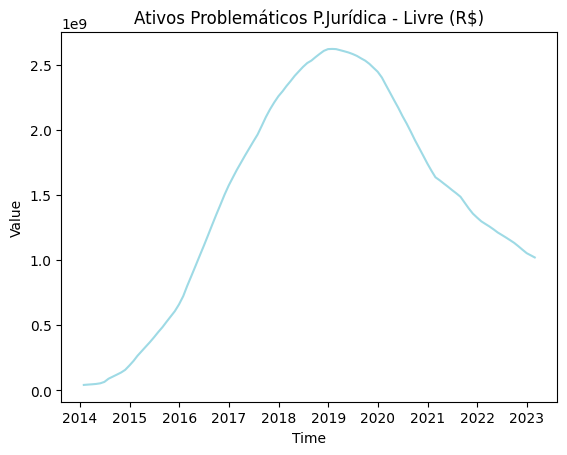

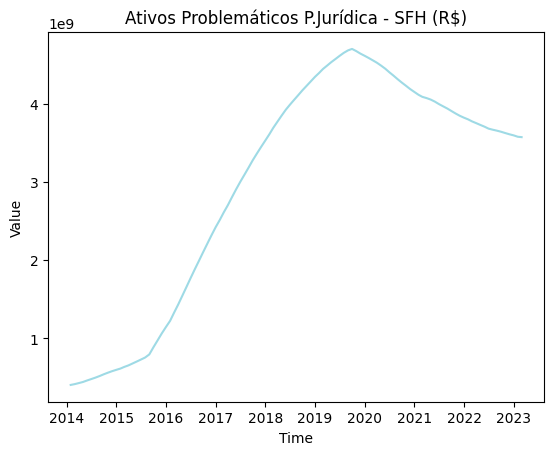

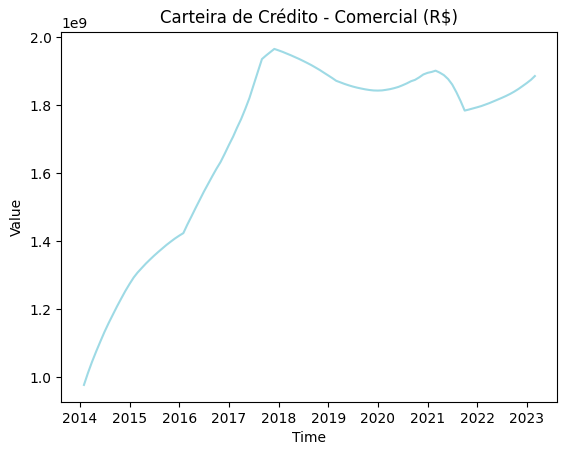

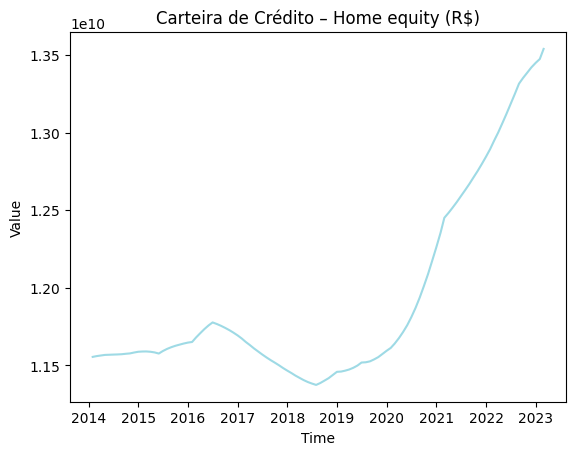

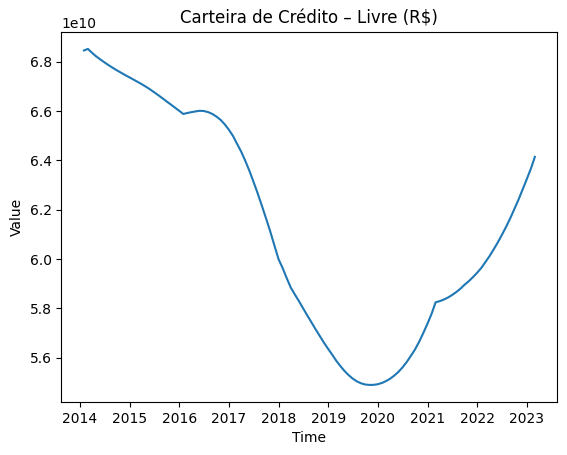

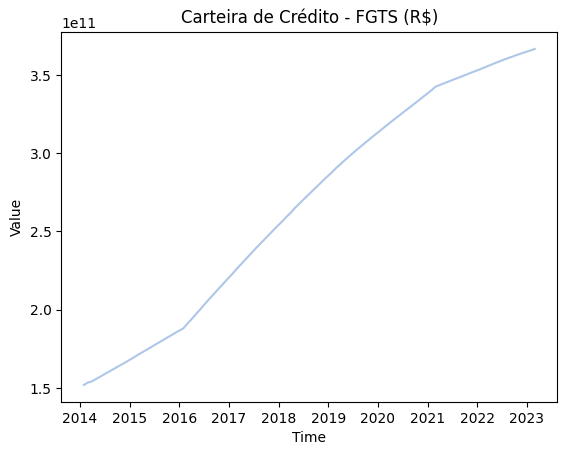

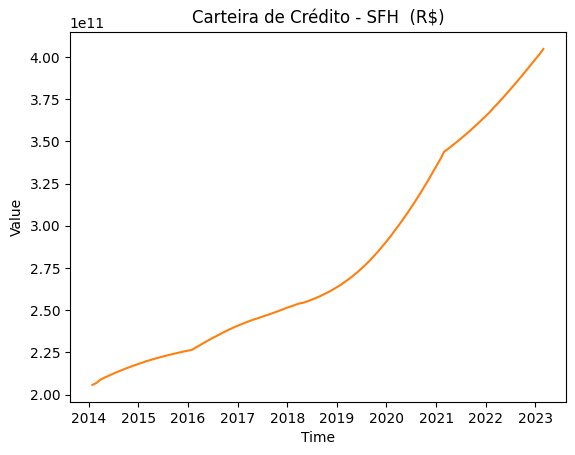

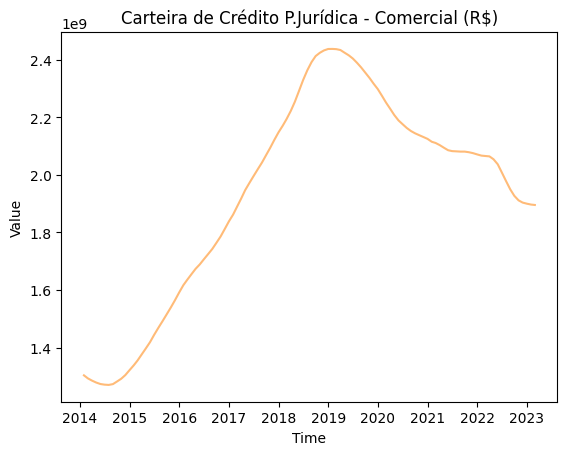

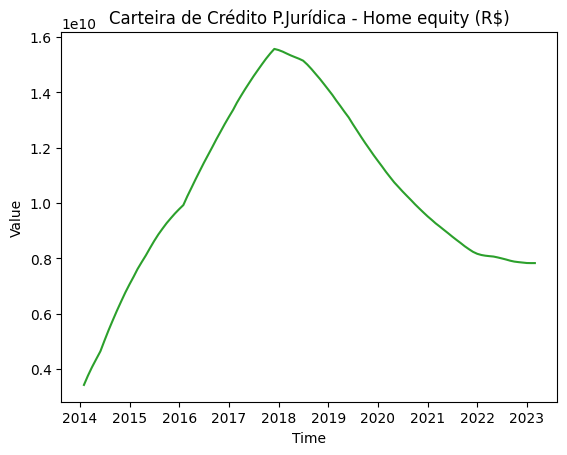

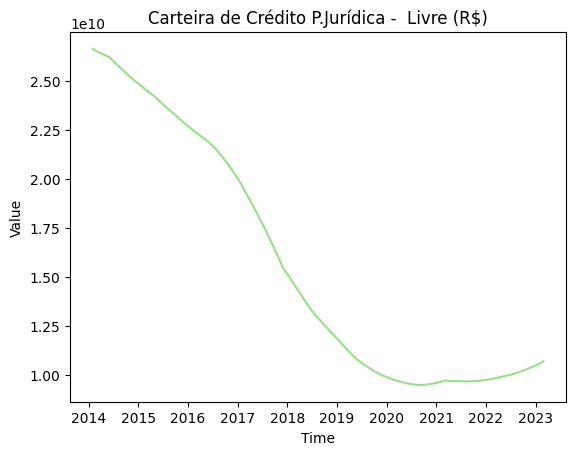

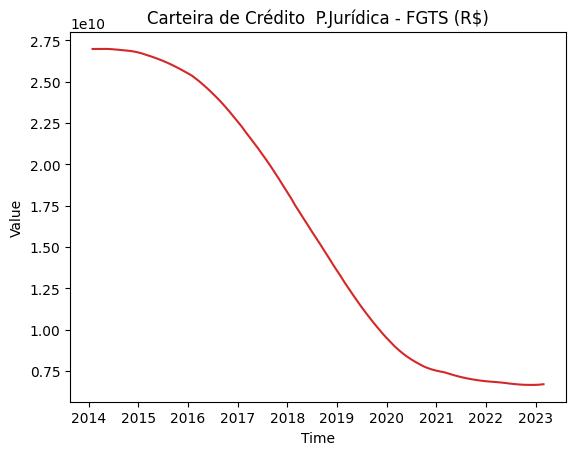

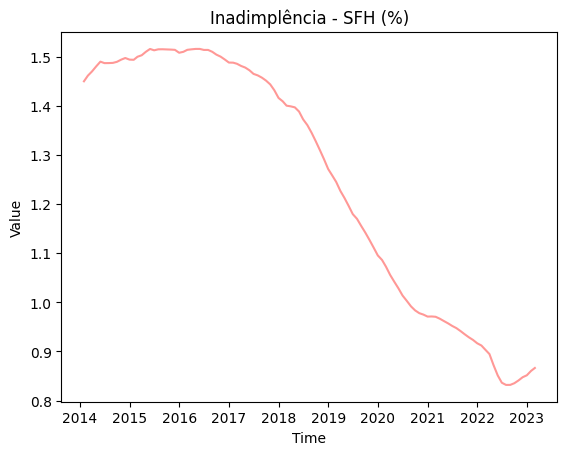

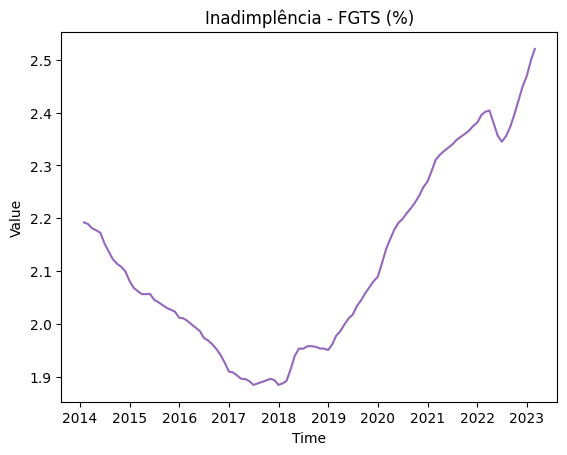

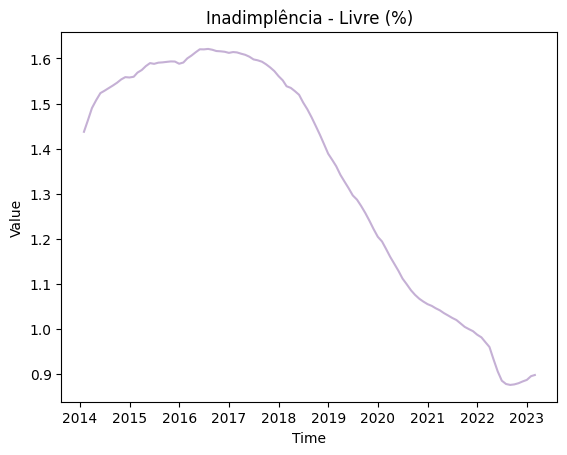

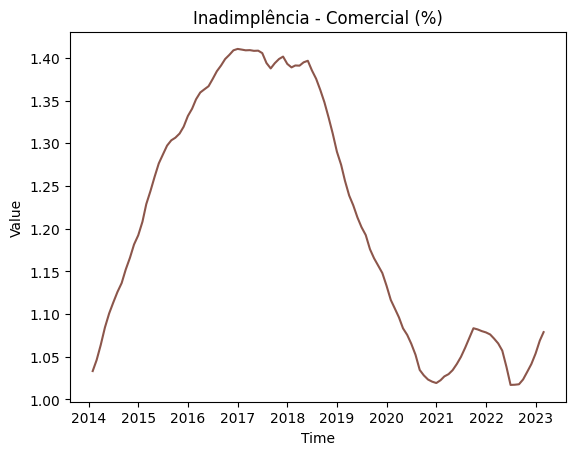

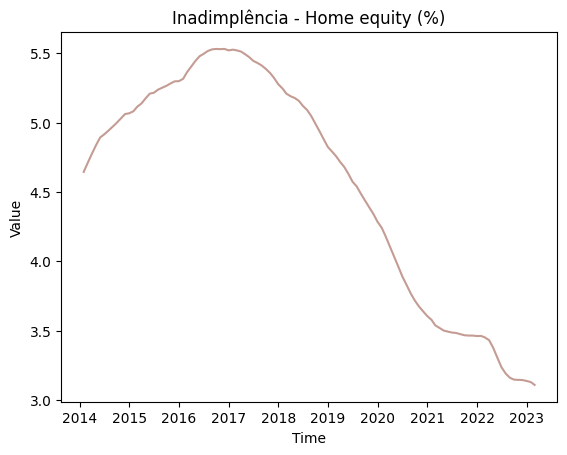

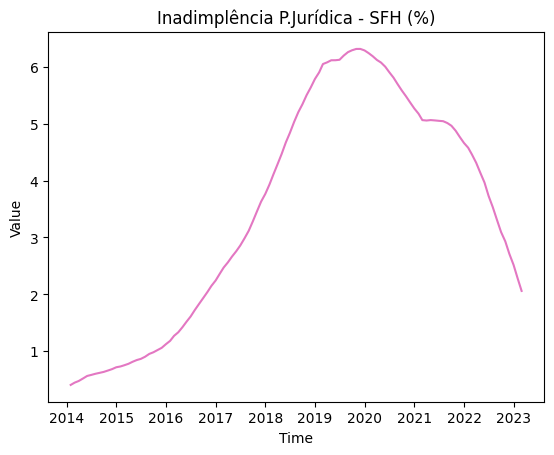

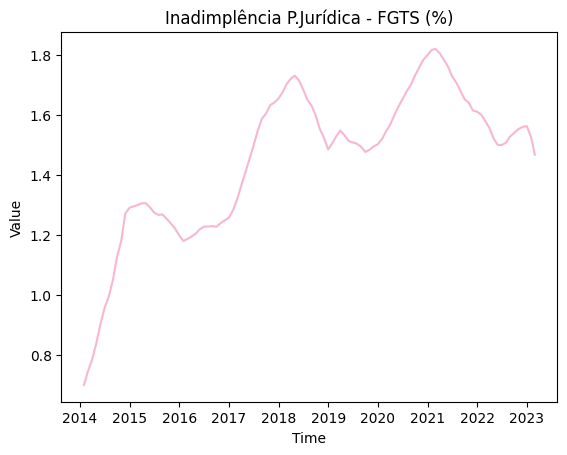

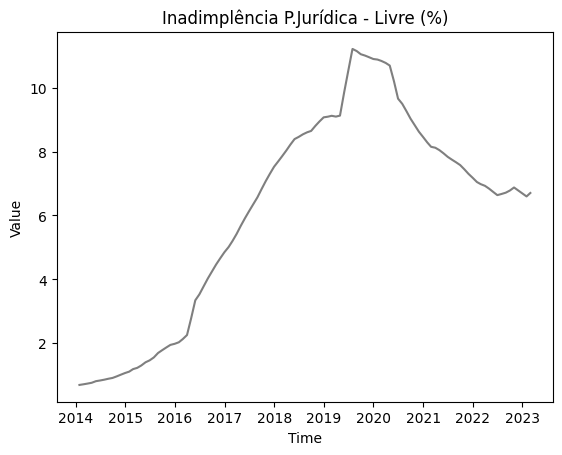

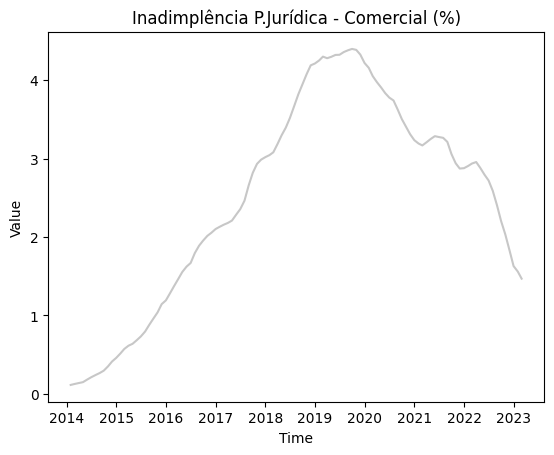

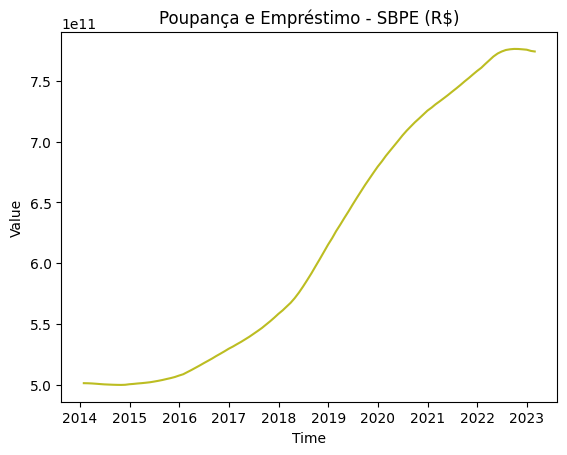

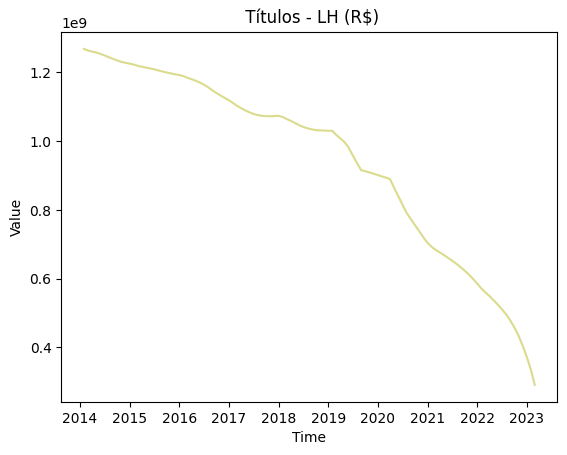

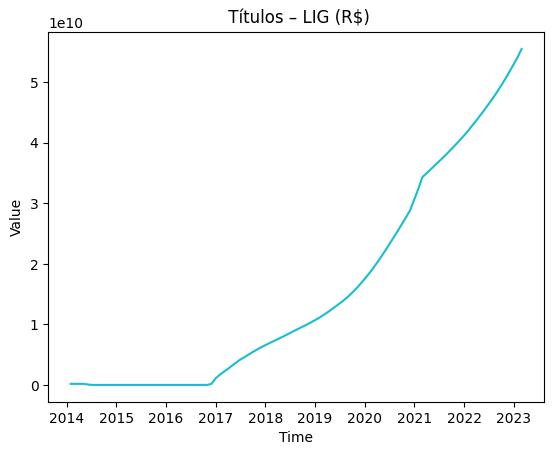

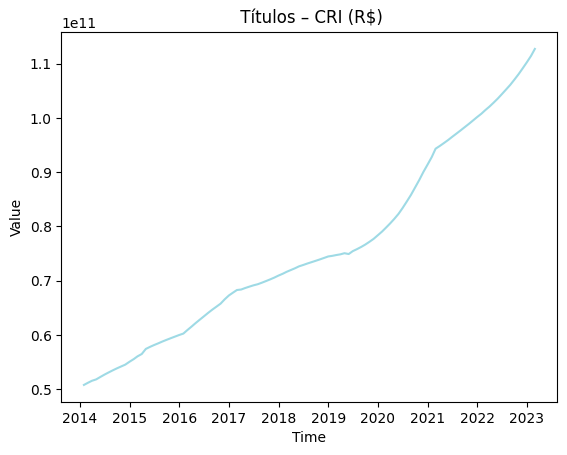

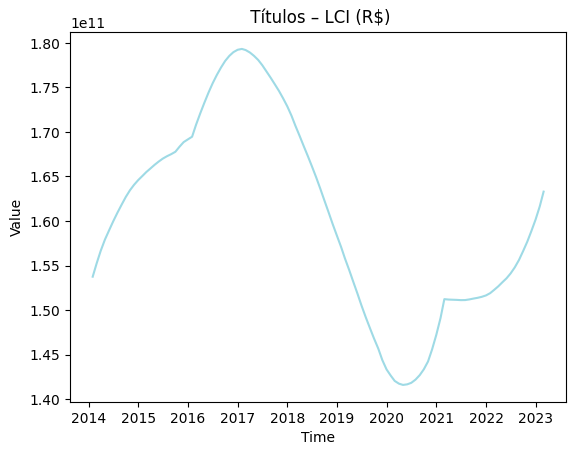

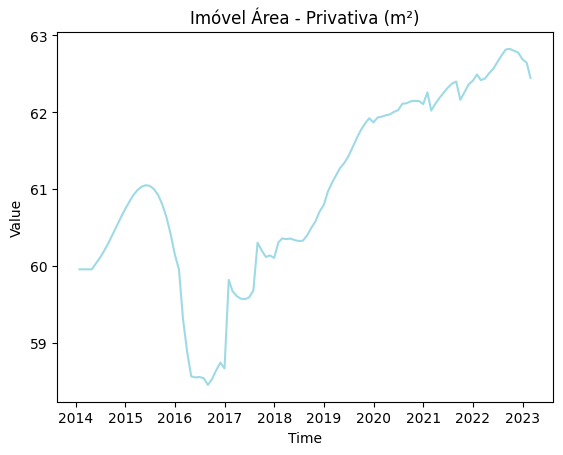

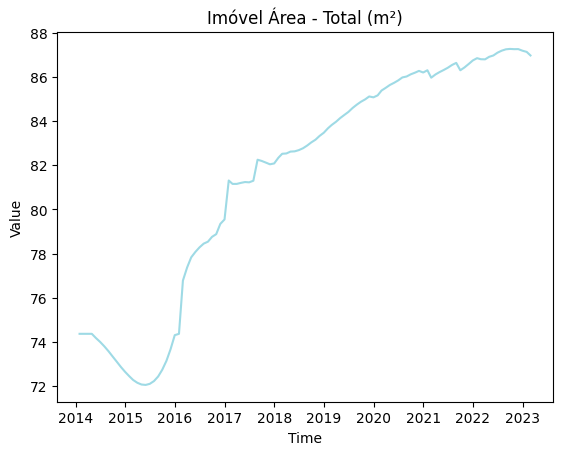

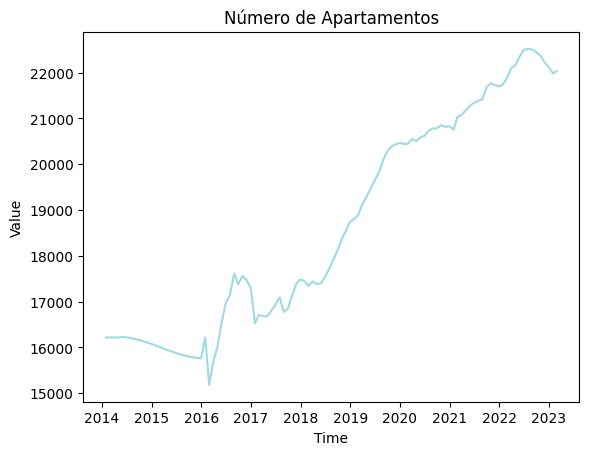

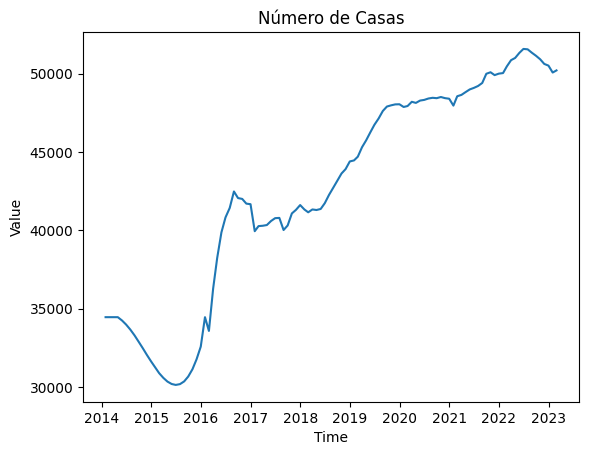

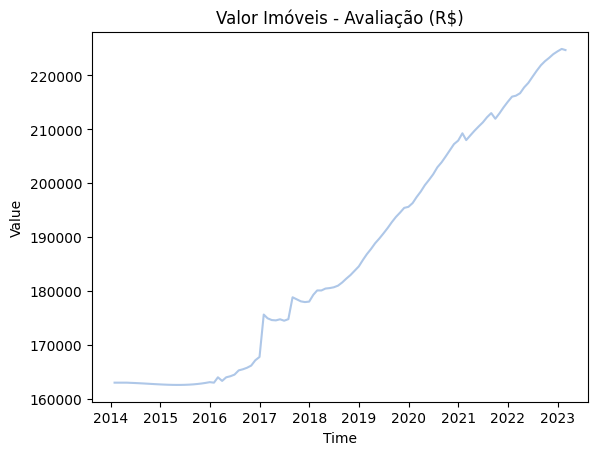

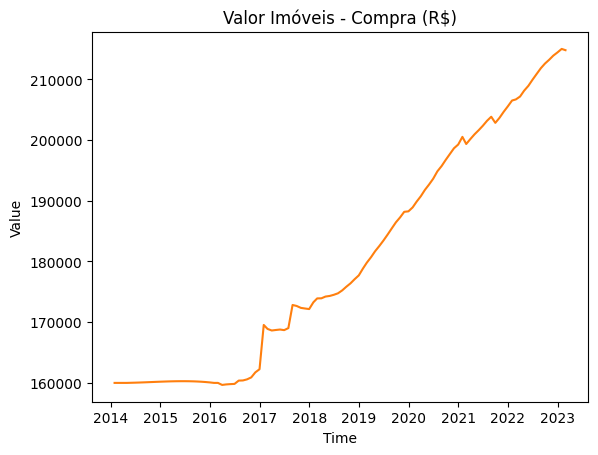

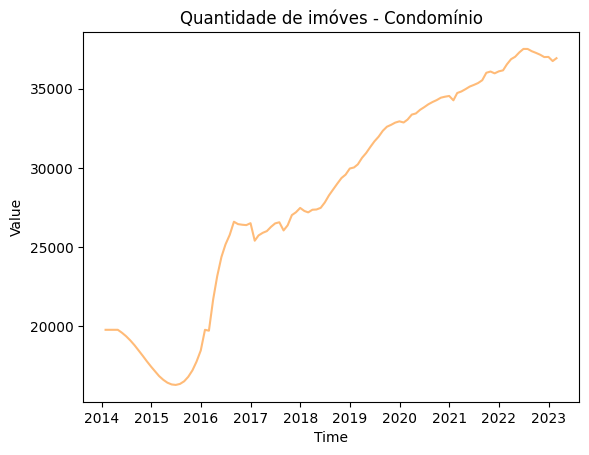

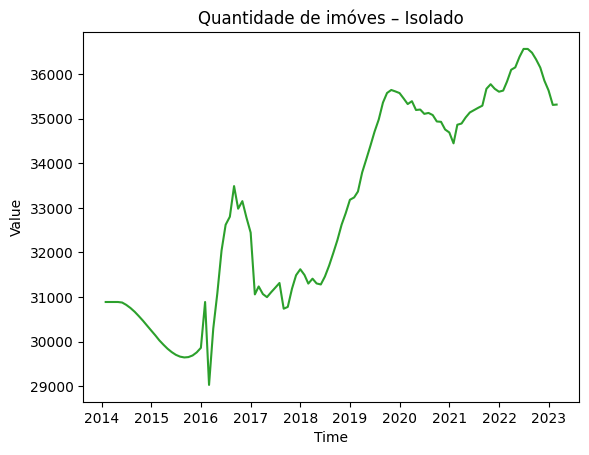

In [11]:
df_interpolated['DateTime'] = pd.to_datetime(df_interpolated['DateTime'])
df_interpolated.set_index('DateTime', inplace=True)
plot_columns(df_interpolated)

In [12]:
colunas_porcentagem = ['Inadimplência - SFH (%)',
                       'Inadimplência - FGTS (%)',
                       'Inadimplência - Livre (%)',
                       'Inadimplência - Comercial (%)',
                       'Inadimplência - Home equity (%)',
                       'Inadimplência P.Jurídica - SFH (%)',
                       'Inadimplência P.Jurídica - FGTS (%)',
                       'Inadimplência P.Jurídica - Livre (%)',
                       'Inadimplência P.Jurídica - Comercial (%)']

df_by_year = df_interpolated.copy()
df_by_year = df_by_year.resample('Y').sum()
df_by_year[colunas_porcentagem] = df_by_year[colunas_porcentagem] /12
df_by_year

,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31,5.449348e+08,2.887184e+09,2.031462e+10,3.985474e+10,4.889827e+10,1.356039e+09,1.131235e+09,4.313727e+09,5.425075e+09,4.024383e+12,2.864056e+11,7.753884e+09,4.313527e+12,2.343492e+08,1.259554e+10,2.270311e+10,1.114626e+11,1.201574e+11,2.356374e+08,6.075208e+09,1.105613e+09,5.931364e+09,1.366134e+10,1.388483e+11,8.152387e+11,1.914441e+12,2.549832e+12,1.544919e+10,6.285418e+10,3.101745e+11,3.231200e+11,1.482409,2.143875,1.519913,1.116256,4.902884,0.575970,0.986663,0.856605,0.243304,6.005062e+12,1.495809e+10,8.045645e+08,6.348594e+11,1.920070e+12,722.817184,885.011630,194172.839978,402074.790336,1.954710e+06,1.920826e+06,227899.376522,368348.253793
2015-12-31,5.073759e+08,2.750548e+09,1.623507e+10,4.238709e+10,4.333567e+10,1.087504e+09,1.462461e+09,3.467632e+09,4.617182e+09,4.287945e+12,3.097479e+11,7.811584e+09,4.487516e+12,3.275533e+08,1.403817e+10,2.519857e+10,1.208504e+11,1.322077e+11,3.673536e+08,9.709072e+09,5.198474e+09,9.635550e+09,1.632086e+10,1.392898e+11,8.001381e+11,2.134927e+12,2.672270e+12,1.750129e+10,1.039877e+11,2.846792e+11,3.140711e+11,1.509815,2.042841,1.584405,1.281167,5.213406,0.901615,1.268174,1.545855,0.812398,6.040005e+12,1.448593e+10,0.000000e+00,6.972099e+11,2.005358e+12,729.823180,871.672415,190538.314148,370087.901411,1.952669e+06,1.922732e+06,202927.383996,357698.831563
2016-12-31,4.782728e+08,2.593105e+09,1.275391e+10,4.511779e+10,3.791924e+10,7.570541e+08,1.924575e+09,2.184352e+09,4.040619e+09,4.705112e+12,3.421705e+11,7.809527e+09,4.840058e+12,4.003126e+08,1.507160e+10,2.716034e+10,1.246387e+11,1.441603e+11,5.606447e+08,1.458234e+10,1.380701e+10,2.190960e+10,1.865617e+10,1.406993e+11,7.897173e+11,2.450900e+12,2.806855e+12,2.064537e+10,1.387988e+11,2.574979e+11,2.892126e+11,1.507993,1.969031,1.612704,1.379388,5.471105,1.687653,1.219949,3.508418,1.730652,6.225718e+12,1.388859e+10,1.275346e+09,7.649028e+11,2.103776e+12,705.473091,936.227573,201081.928355,474594.594697,1.980729e+06,1.925304e+06,292062.404437,383614.118615
2017-12-31,4.379709e+08,2.470784e+09,8.299166e+09,4.623055e+10,3.464453e+10,7.695911e+08,2.751679e+09,1.413790e+09,3.996627e+09,5.295174e+12,3.965520e+11,7.621452e+09,5.199721e+12,4.732969e+08,1.5129

In [17]:
df_csv = df_by_year.copy()
df_csv['Ano'] = df_csv.index.year
df_csv.set_index('Ano', inplace=True)
df_csv

,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
Ano,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,5.449348e+08,2.887184e+09,2.031462e+10,3.985474e+10,4.889827e+10,1.356039e+09,1.131235e+09,4.313727e+09,5.425075e+09,4.024383e+12,2.864056e+11,7.753884e+09,4.313527e+12,2.343492e+08,1.259554e+10,2.270311e+10,1.114626e+11,1.201574e+11,2.356374e+08,6.075208e+09,1.105613e+09,5.931364e+09,1.366134e+10,1.388483e+11,8.152387e+11,1.914441e+12,2.549832e+12,1.544919e+10,6.285418e+10,3.101745e+11,3.231200e+11,1.482409,2.143875,1.519913,1.116256,4.902884,0.575970,0.986663,0.856605,0.243304,6.005062e+12,1.495809e+10,8.045645e+08,6.348594e+11,1.920070e+12,722.817184,885.011630,194172.839978,402074.790336,1.954710e+06,1.920826e+06,227899.376522,368348.253793
2015,5.073759e+08,2.750548e+09,1.623507e+10,4.238709e+10,4.333567e+10,1.087504e+09,1.462461e+09,3.467632e+09,4.617182e+09,4.287945e+12,3.097479e+11,7.811584e+09,4.487516e+12,3.275533e+08,1.403817e+10,2.519857e+10,1.208504e+11,1.322077e+11,3.673536e+08,9.709072e+09,5.198474e+09,9.635550e+09,1.632086e+10,1.392898e+11,8.001381e+11,2.134927e+12,2.672270e+12,1.750129e+10,1.039877e+11,2.846792e+11,3.140711e+11,1.509815,2.042841,1.584405,1.281167,5.213406,0.901615,1.268174,1.545855,0.812398,6.040005e+12,1.448593e+10,0.000000e+00,6.972099e+11,2.005358e+12,729.823180,871.672415,190538.314148,370087.901411,1.952669e+06,1.922732e+06,202927.383996,357698.831563
2016,4.782728e+08,2.593105e+09,1.275391e+10,4.511779e+10,3.791924e+10,7.570541e+08,1.924575e+09,2.184352e+09,4.040619e+09,4.705112e+12,3.421705e+11,7.809527e+09,4.840058e+12,4.003126e+08,1.507160e+10,2.716034e+10,1.246387e+11,1.441603e+11,5.606447e+08,1.458234e+10,1.380701e+10,2.190960e+10,1.865617e+10,1.406993e+11,7.897173e+11,2.450900e+12,2.806855e+12,2.064537e+10,1.387988e+11,2.574979e+11,2.892126e+11,1.507993,1.969031,1.612704,1.379388,5.471105,1.687653,1.219949,3.508418,1.730652,6.225718e+12,1.388859e+10,1.275346e+09,7.649028e+11,2.103776e+12,705.473091,936.227573,201081.928355,474594.594697,1.980729e+06,1.925304e+06,292062.404437,383614.118615
2017,4.379709e+08,2.470784e+09,8.299166e+09,4.623055e+10,3.464453e+10,7.695911e+08,2.751679e+09,1.413790e+09,3.996627e+09,5.295174e+12,3.965520e+11,7.621452e+09,5.199721e+12,4.732969e+08,1.512967e+10,2.800587e+10,1.273712e

In [21]:
df_csv.to_csv('imob_01_2014.csv', index=True)